# Юнит 2, проект 2, Разведывательный анализ данных

Основные цели и задачи проекта:
 1. Первичную обработка данных.
 2. Просмотр распределения признака для числовых переменных, устранение выбросов.
 3. Оценка количества уникальных значений для номинативных переменных.
 4. Корреляционный анализ количественных переменных и отбор некоррелирующих.
 5. Анализируйте номинативных переменных и устранение тех, которые не влияют на предсказываемую величину score.
 6. Выводы относительно качества данных и переменных, которые будут использоваться в дальнейшем построении модели.

Этапы работы над проектом:
 1. Примитивный быстрый подход
 2. Очистка данных
 3. Анализ количественных переменных с помощью корреляционного анализа
 4. Анализ номинативных переменных с помощью теста Стьюдента
 5. Выводы

In [978]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

%matplotlib inline

In [979]:
#список значений, включая NaN
def value_counts_short(input_column, asc=False):
    vc = input_column.value_counts(dropna=False)
    #vc = pd.DataFrame(sorted(input_column.value_counts(dropna=False)))
    print("Уникальных значений: ", input_column.nunique())
    print(vc.sort_values(ascending=asc))

In [980]:
# отрисовка гистограммы и боксплота для не NaN-значений, а также вывод информации о значениях
# осмысленно для циферных
def simple_info_not_na(input_column):
    value_counts_short(input_column)
    
    sub_column = input_column.loc[pd.notnull(input_column)]
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].hist(sub_column)
    axes[0].set_title(sub_column.name + ' hist')

    axes[1].boxplot(sub_column)
    axes[1].set_title(sub_column.name + ' box plot')

In [981]:
# функция отрисовки гистограммы cучетом NaN (чтобы видно было на гистограмме)
def get_hist_with_nan(input_column):
    ic = input_column.apply(lambda x: 'Nan-unknown' if not pd.notnull(x) else x)
    ic.hist()

In [982]:
# отрисовка гистограммы и вывод информации о значениях, для категориальных
def simple_info_cat(input_column):
    value_counts_short(input_column)
    get_hist_with_nan(input_column) #input_column.hist()

In [983]:
# отрисвка с использованием значений квантилей
def pic_iqr_global(what_to_pic, bins_here, range_left, range_right):
    IQR = what_to_pic.quantile(0.75) - what_to_pic.quantile(0.25)
    perc25 = what_to_pic.quantile(0.25)
    perc75 = what_to_pic.quantile(0.75)

    print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

    what_to_pic.loc[what_to_pic.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(
        alpha = 0.5, bins = bins_here, range = (range_left, range_right), label = 'IQR')
    
    plt.legend();
    
    return (IQR, perc25, perc75)

In [984]:
# функция преобразующая бинарные принаки, на вход что приводить к 1
def apply_reeval(input_column, base_value):
    return input_column.astype(str).apply(lambda x: 1 if x == base_value else 0)

In [985]:
# функция отрисовки гистограммы колонки, переведенной в цифру
# -1 для NaN
def get_digital_view(input_column):
    vc = input_column.value_counts(dropna=False)
    
    val_dict = {}
    counter = 0
    for v in vc.index:    
        if (pd.notnull(v)):
            val_dict[v] = counter
            counter = counter + 1
        else:
            val_dict[v] = -1
            
    ic = input_column.apply(lambda x: -1 if not pd.notnull(x) else val_dict[x])
    ic.hist()

In [986]:
# гистограмма одного столбца по каждому значению столбца
def by_group_hists(df_to_process, name1, name2):
    not_null_medu_fedu_subdf = df_to_process.loc[(pd.notnull(df_to_process[name1])) & (pd.notnull(df_to_process[name2]))]
    medu_fedu_grp = not_null_medu_fedu_subdf.groupby(by = name2)[name1]
    lst_l = list(medu_fedu_grp.indices.keys())
    rowc = int(len(lst_l)/2)+1
    f,a = plt.subplots(rowc, 2, figsize=(10, 5*rowc), sharex='row')

    a = a.ravel()
    cnt_id = 0
    for idx,ax in enumerate(a):
        if (cnt_id >= len(lst_l)):
            break
        ax.hist(medu_fedu_grp.get_group(lst_l[cnt_id]), orientation='vertical')
        ax.set_title(lst_l[cnt_id])
        cnt_id = cnt_id + 1

In [987]:
# функция распечатки значений матрицы корреляций выше заданного
def print_corr_over_threshold(correlation_in, threshold_in):
    np.fill_diagonal(correlation_in.values, -2)
    for i, ii in zip(correlation_in.columns, enumerate(correlation_in.columns)):
        for j, jj in zip(correlation_in.columns, enumerate(correlation_in.columns)):
            if (i==j):
                continue
            if (ii < jj):
                continue
            if (abs(correlation_in[i][j]) > threshold_in and abs(correlation_in[i][j]) < 2):
                print(i, '\t', j, '\t', correlation_in[i][j])

In [993]:
# удалить все NaN, сделав копию
def clean_df(input_df):
    input_df_cleaned = input_df.copy()
    for x in input_df_cleaned.columns:
        input_df_cleaned = input_df_cleaned.loc[pd.notnull(input_df_cleaned[x])]
    #input_df_cleaned.info(verbose=True, null_counts=True)
    return input_df_cleaned

In [994]:
# нарисовать heatmap корреляци, вывести все пары выше заданных двух порогов - явной корреляции и хоть какой-то для интереса
def correlation_workflow(input_df, threshold_in1, threshold_in2):
    correlation_input_df = input_df.corr()
    correlation_input_df
    sns.heatmap(correlation_input_df, annot=True, cmap='BuPu')
    fig = plt.gcf().set_size_inches(15, 15)
    print("---------Correlated---------")
    print_corr_over_threshold(correlation_input_df, threshold_in1)
    print('---------end--------')
    print("---------Just something correlated---------")
    print_corr_over_threshold(correlation_input_df, threshold_in2)
    print('---------end--------')

In [995]:
# порог для коррелирующего признака и хоть для чего-то
threshold_corr = 0.7
threshold_corr_at_least = 0.149

In [996]:
# найти статистически значимые различия, предполагая что NaN нету
def get_stat_dif(input_df, column):
    cols = input_df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(input_df.loc[input_df.loc[:, column] == comb[0], 'score'], 
                        input_df.loc[input_df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
    #else:
    #    print("no", column)

In [997]:
# найти статистически значимые различия без учета NaN
def get_stat_dif_no_na(input_df, column):
    cols = input_df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(input_df.loc[input_df.loc[:, column] == comb[0], 'score'].dropna(), 
                        input_df.loc[input_df.loc[:, column] == comb[1], 'score'].dropna()).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
    #else:
    #    print("no", column)

### Колонки

* 1 school — аббревиатура школы, в которой учится ученик
* 2 sex — пол ученика ('F' - женский, 'M' - мужской)
* 3 age — возраст ученика (от 15 до 22)
* 4 address — тип адреса ученика ('U' - городской, 'R' - за городом)
* 5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)
* 6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
* 7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

* 8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

* 9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

* 10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

* 11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

* 12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
* 13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
* 14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

* 15 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
* 16 schoolsup — дополнительная образовательная поддержка (yes или no)
* 17 famsup — семейная образовательная поддержка (yes или no)
* 18 paid — дополнительные платные занятия по математике (yes или no)
* 19 activities — дополнительные внеучебные занятия (yes или no)
* 20 nursery — посещал детский сад (yes или no)
* 21 higher — хочет получить высшее образование (yes или no)
* 22 internet — наличие интернета дома (yes или no)
* 23 romantic — в романтических отношениях (yes или no)
* 24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
* 25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
* 26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
* 27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
* 28 absences — количество пропущенных занятий
* 29 score — баллы по госэкзамену по математике


# Начало 

In [998]:
stud_df = pd.read_csv('stud_math.csv')
stud_df.head(n=5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [999]:
stud_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

In [1000]:
# Мы видим, что колонок 30 вместо заявленных 29. Также очевидно,что есть NaN'ы
# Найдем лишнюю

In [1001]:
# список колонок из задания
src_task_list = ['school','sex','age','address','famsize','Pstatus','Medu','Fedu','Mjob','Fjob','reason',
            'guardian','traveltime','studytime','failures','schoolsup','famsup','paid','activities',
            'nursery','higher','internet','romantic','famrel','freetime',
            'goout','health','absences','score',
]

In [1002]:
# Лишняя колонка
[x for x in stud_df.columns if x not in src_task_list]

['studytime, granular']

In [1003]:
# Проверим на всякий случай, что нет пропавших колонок
[x for x in src_task_list if x not in stud_df.columns]

[]

In [1004]:
# приведем все к нижнему кейсу, а также уберем пунктуацию из имен колонок
stud_df.columns = [t.replace(',', '_').replace(' ', '').lower() for t in stud_df.columns]
stud_df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
       'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [1005]:
stud_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                395 non-null object
sex                   395 non-null object
age                   395 non-null int64
address               378 non-null object
famsize               368 non-null object
pstatus               350 non-null object
medu                  392 non-null float64
fedu                  371 non-null float64
mjob                  376 non-null object
fjob                  359 non-null object
reason                378 non-null object
guardian              364 non-null object
traveltime            367 non-null float64
studytime             388 non-null float64
failures              373 non-null float64
schoolsup             386 non-null object
famsup                356 non-null object
paid                  355 non-null object
activities            381 non-null object
nursery               379 non-null object
studytime_granular    388 non-null float64
higher  

# 1.1 Примитивный быстрый подход.
## Первая попытка анализа в лоб

In [1006]:
# Проведем первую попытку анализа совсем в лоб
# 1) просто сделаем heatmap без исследования

In [1007]:
correlation_at_start = stud_df.corr()
correlation_at_start

,age,medu,fedu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,absences,score
age,1.000000,-0.161704,-0.138018,0.081508,-0.015556,0.228047,0.015556,0.068899,0.029023,0.135107,-0.065946,0.093592,-0.155726
medu,-0.161704,1.000000,0.275598,-0.173515,0.078589,-0.245463,-0.078589,-0.010050,0.025335,0.064164,-0.045051,-0.011944,0.213349
fedu,-0.138018,0.275598,1.000000,0.030646,0.057199,-0.150821,-0.057199,0.040577,-0.066556,-0.023282,0.027251,0.004695,0.078573
traveltime,0.081508,-0.173515,0.030646,1.000000,-0.102206,0.064699,0.102206,-0.016857,-0.021937,0.037636,-0.021531,-0.048215,-0.070559
studytime,-0.015556,0.078589,0.057199,-0.102206,1.000000,-0.178992,-1.000000,0.045894,-0.121969,-0.051280,-0.080016,-0.026544,0.115741
failures,0.228047,-0.245463,-0.150821,0.064699,-0.178992,1.000000,0.178992,-0.022655,0.098382,0.120914,0.081284,0.057391,-0.344338
studytime_granular,0.015556,-0.078589,-0.057199,0.102206,-1.000000,0.178992,1.000000,-0.045894,0.121969,0.051280,0.080016,0.026544,-0.115741
famrel,0.068899,-0.010050,0.040577,-0.016857,0.045894,-0.022655,-0.045894,1.000000,0.175743,0.081154,0.077474,-0.082609,0.057112
freetime,0.029023,0.025335,-0.066556,-0.021937,-0.121969,0.098382,0.121969,0.175743,1.000000,0.296437,0.061575,0.009292,0.019026
goout,0.135107,0.064164,-0.023282,0.037636,-0.051280,0.120914,0.051280,0.081154,0.296437,1.000000,-0.015608,-0.048738,-0.129685


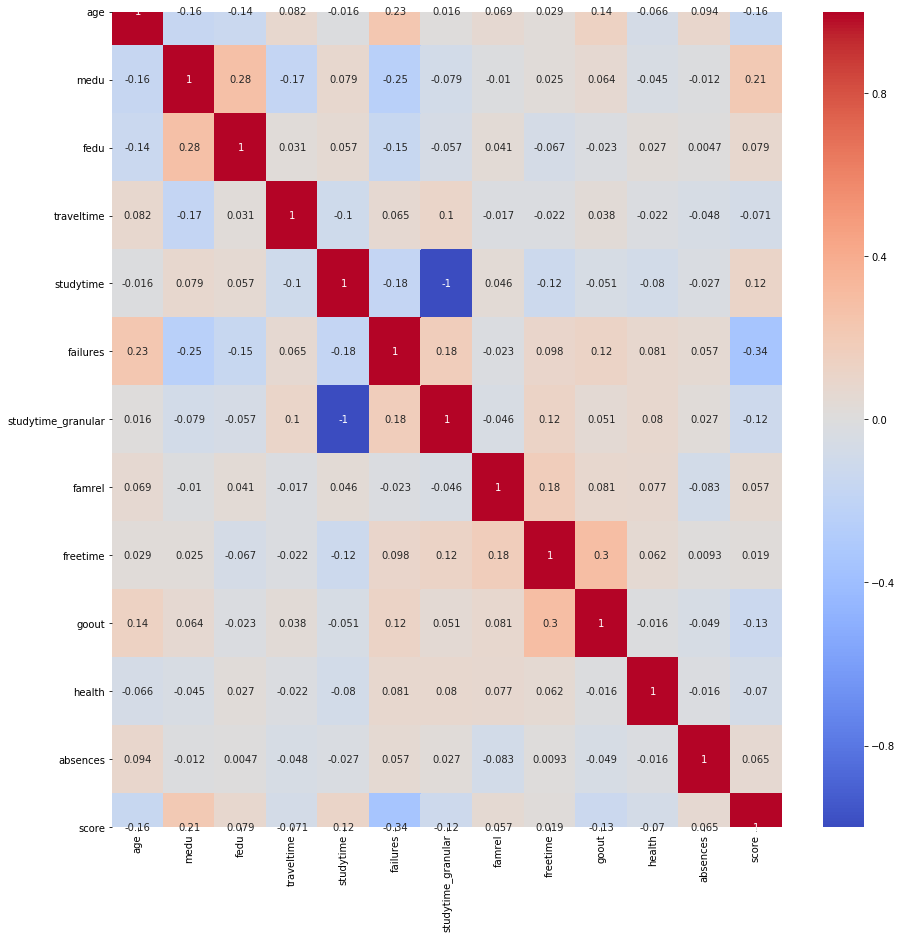

In [1008]:
sns.heatmap(correlation_at_start, annot=True, cmap='coolwarm')
fig = plt.gcf().set_size_inches(15, 15)

In [1009]:
# видим корелляцию между как раз лишней studytime_granular и studytime, посмотрим на них
stud_df[['studytime_granular', 'studytime']].sample(10)

,studytime_granular,studytime
344,-9.0,3.0
379,-6.0,2.0
267,-6.0,2.0
123,-3.0,1.0
303,-12.0,4.0
337,-6.0,2.0
15,-3.0,1.0
166,-6.0,2.0
297,-6.0,2.0
228,-6.0,2.0


In [1010]:
# видим даже зависимость, проверим
stud_df.loc[stud_df.studytime_granular != -3*stud_df.studytime]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
17,GP,F,16,U,GT3,T,3.0,3.0,other,NaN,reputation,mother,3.0,NaN,0.0,yes,NaN,no,yes,yes,NaN,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0
91,GP,F,15,U,GT3,T,4.0,3.0,services,other,reputation,mother,1.0,NaN,NaN,no,no,yes,yes,yes,NaN,yes,yes,no,4.0,5.0,5.0,1.0,4.0,90.0
112,GP,F,16,U,GT3,NaN,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,yes,no,no,yes,yes,NaN,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0
227,GP,M,17,U,LE3,NaN,2.0,3.0,services,services,reputation,father,1.0,NaN,0.0,no,yes,yes,no,no,NaN,NaN,yes,no,5.0,3.0,3.0,3.0,NaN,60.0
266,GP,M,17,U,GT3,NaN,3.0,1.0,services,NaN,other,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,NaN,5.0,4.0,4.0,NaN,2.0,50.0
314,GP,F,19,U,GT3,T,1.0,1.0,at_home,health,home,other,1.0,NaN,2.0,no,no,no,no,no,NaN,yes,yes,yes,4.0,NaN,2.0,3.0,14.0,65.0


In [1011]:
# всего 7 строк из 395 и все NaN, очевидно один из двух столбцов можно удалить, уберем незадокументированный
stud_df.drop(['studytime_granular'], inplace = True, axis = 1)

# 1.2 Примитивный быстрый подход. 
## Вторая попытка анализа в лоб

In [1012]:
# уберем все вообще NaN
stud_df_copy = stud_df.copy()
for x in stud_df_copy.columns:
    stud_df_copy = stud_df_copy.loc[pd.notnull(stud_df_copy[x])]
stud_df_copy.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 4 to 391
Data columns (total 29 columns):
school        97 non-null object
sex           97 non-null object
age           97 non-null int64
address       97 non-null object
famsize       97 non-null object
pstatus       97 non-null object
medu          97 non-null float64
fedu          97 non-null float64
mjob          97 non-null object
fjob          97 non-null object
reason        97 non-null object
guardian      97 non-null object
traveltime    97 non-null float64
studytime     97 non-null float64
failures      97 non-null float64
schoolsup     97 non-null object
famsup        97 non-null object
paid          97 non-null object
activities    97 non-null object
nursery       97 non-null object
higher        97 non-null object
internet      97 non-null object
romantic      97 non-null object
famrel        97 non-null float64
freetime      97 non-null float64
goout         97 non-null float64
health        97 non-null float

In [1013]:
# всего 97 значений из изначальных 397, много незаполненных данных

In [1014]:
correlation_cleaned = stud_df_copy.corr()
correlation_cleaned

,age,medu,fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.071662,-0.056929,0.143682,-0.220209,0.320914,0.057039,0.040115,0.106748,0.037152,0.142780,-0.186407
medu,-0.071662,1.000000,0.684379,-0.248099,-0.042491,-0.135065,-0.032146,-0.032350,0.023938,-0.124250,0.101253,0.064914
fedu,-0.056929,0.684379,1.000000,-0.162149,-0.001350,-0.189926,-0.059084,-0.135575,-0.087894,0.086575,0.059172,-0.014236
traveltime,0.143682,-0.248099,-0.162149,1.000000,-0.034571,-0.029138,-0.134113,-0.071376,-0.094331,0.147160,-0.148719,-0.094874
studytime,-0.220209,-0.042491,-0.001350,-0.034571,1.000000,-0.016541,0.025253,-0.226503,-0.129162,-0.067115,-0.018695,-0.029742
failures,0.320914,-0.135065,-0.189926,-0.029138,-0.016541,1.000000,-0.095520,-0.043110,-0.021022,0.057279,0.239602,-0.314698
famrel,0.057039,-0.032146,-0.059084,-0.134113,0.025253,-0.095520,1.000000,0.084336,0.069922,0.178145,0.016312,-0.026742
freetime,0.040115,-0.032350,-0.135575,-0.071376,-0.226503,-0.043110,0.084336,1.000000,0.381049,0.120714,0.093512,0.068862
goout,0.106748,0.023938,-0.087894,-0.094331,-0.129162,-0.021022,0.069922,0.381049,1.000000,-0.033206,0.094859,-0.079187
health,0.037152,-0.124250,0.086575,0.147160,-0.067115,0.057279,0.178145,0.120714,-0.033206,1.000000,-0.019866,-0.103462


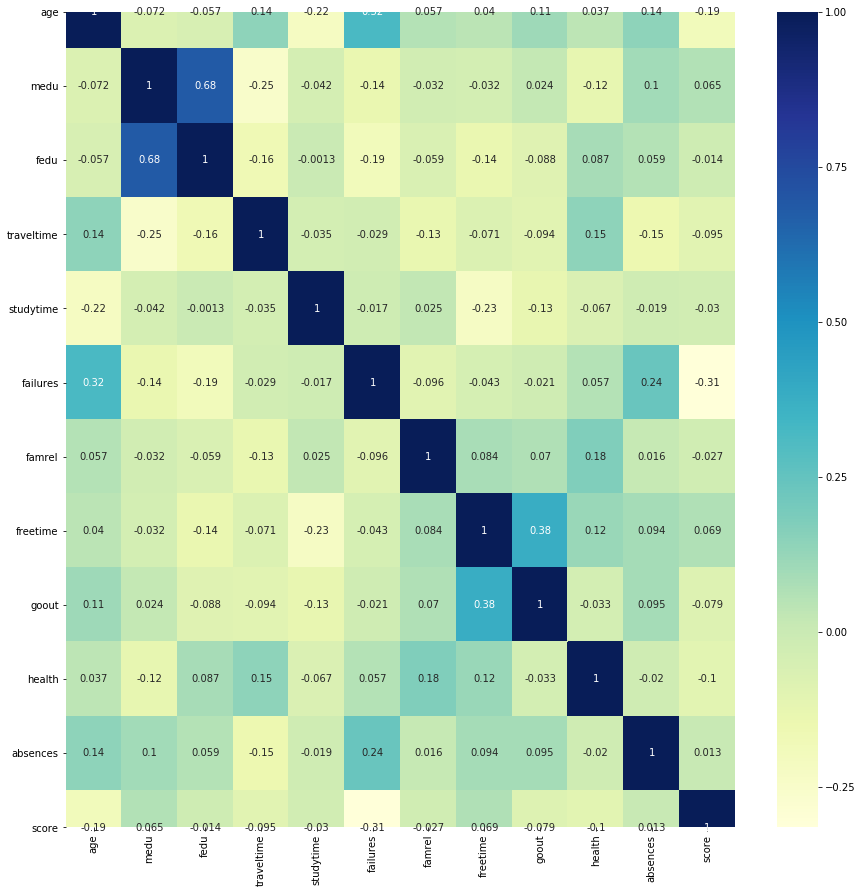

In [1015]:
sns.heatmap(correlation_cleaned, annot=True, cmap='YlGnBu')
fig = plt.gcf().set_size_inches(15, 15)

In [1016]:
# интересно что резко увеличилась корреляция между fedu/medu

## 2. Анализ и обработка/очистка данных

In [1017]:
# Теперь будем рассматривать колонки

In [1018]:
# 1. school

Уникальных значений:  2
GP    349
MS     46
Name: school, dtype: int64


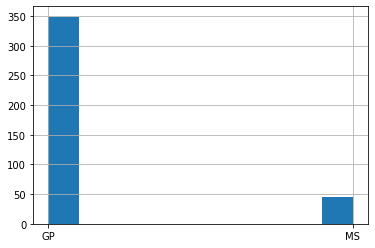

In [1019]:
simple_info_cat(stud_df.school)

In [1021]:
# Ничего необчного пока, оставим как есть

In [1022]:
# 2. sex

Уникальных значений:  2
F    208
M    187
Name: sex, dtype: int64


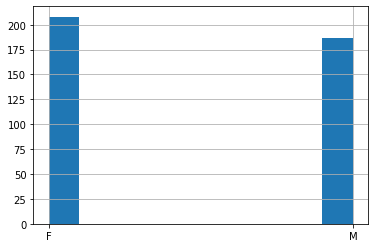

In [1023]:
simple_info_cat(stud_df.sex)

In [1024]:
# Ничего необчного пока, оставим

In [1025]:
# 3. age

Уникальных значений:  8
16    104
17     98
15     82
18     82
19     24
20      3
21      1
22      1
Name: age, dtype: int64


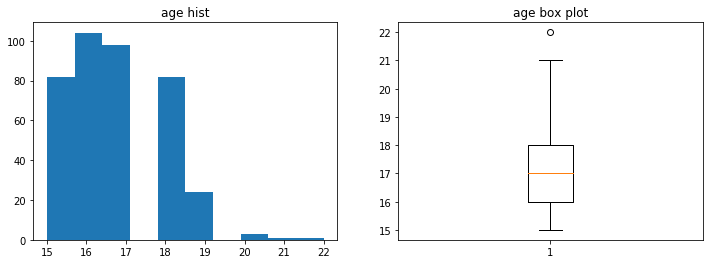

In [1026]:
simple_info_not_na(stud_df.age)

In [1027]:
# Смотря на значения и гистограмму понятно, что основная масса 15-19 лет, 
# 22 и, судя по гистограмме даже 20-21 кажутся выбросами, но исходя из смысла - просто редкие значения.
#Оставим.
### Если передумаем:
### stud_df = stud_df.loc[stud_df.age < 20]

Уникальных значений:  5
16    104
17     98
15     82
18     82
19     24
Name: age, dtype: int64


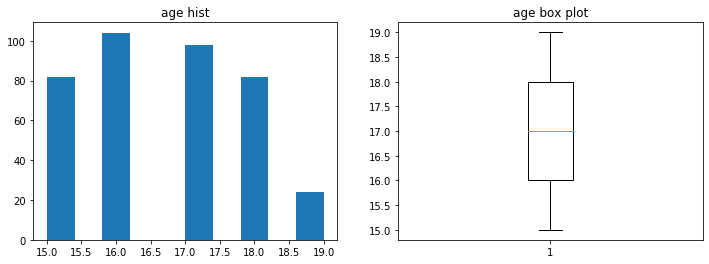

In [1036]:
# но посмотрим ещё и как будто без них
simple_info_not_na(stud_df.age.loc[stud_df.age < 20])

In [1037]:
# 4. Address

Уникальных значений:  2
U      295
R       83
NaN     17
Name: address, dtype: int64


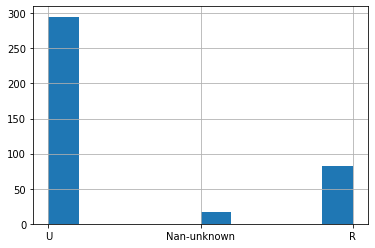

In [1038]:
simple_info_cat(stud_df.address)

In [1039]:
# Ничего необчного пока, но часть неизвестна, оставим, может позже переделаем в признак

In [1040]:
# 5. famsize

Уникальных значений:  2
GT3    261
LE3    107
NaN     27
Name: famsize, dtype: int64


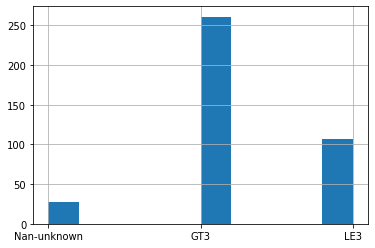

In [1041]:
simple_info_cat(stud_df.famsize)

In [1042]:
# Ничего необчного пока, но часть неизвестна, оставим, может позже переделаем в признак

In [1043]:
# 6. Pstatus 

Уникальных значений:  2
T      314
NaN     45
A       36
Name: pstatus, dtype: int64


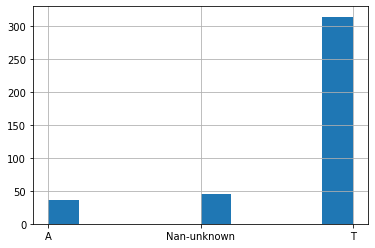

In [1044]:
simple_info_cat(stud_df.pstatus)

In [1045]:
# Ничего необчного пока, но часть неизвестна, оставим, может позже переделаем в признак

In [1046]:
# 7. medu, fedu

Уникальных значений:  5
4.0    131
2.0    102
3.0     97
1.0     59
NaN      3
0.0      3
Name: medu, dtype: int64


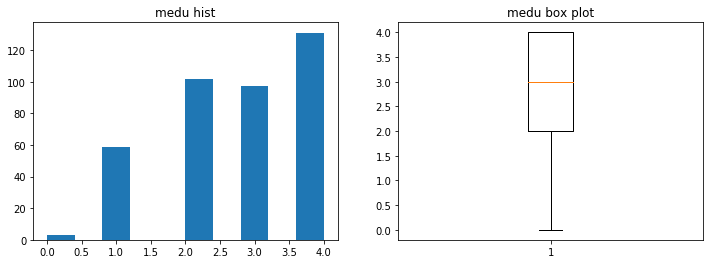

In [1047]:
simple_info_not_na(stud_df.medu)

Уникальных значений:  6
2.0     106
3.0      96
4.0      88
1.0      78
NaN      24
0.0       2
40.0      1
Name: fedu, dtype: int64


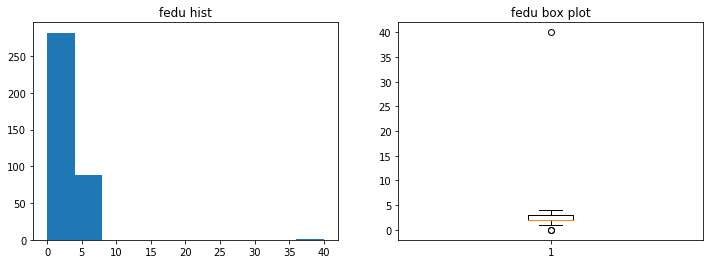

In [1048]:
simple_info_not_na(stud_df.fedu)

Уникальных значений:  5
2.0    106
3.0     96
4.0     88
1.0     78
NaN     24
0.0      2
Name: fedu, dtype: int64


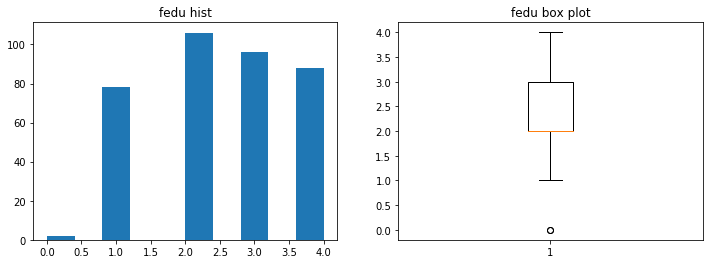

In [1049]:
# удалим явно неверные значения и перепостроим
stud_df = stud_df.loc[(stud_df.fedu <= 4.0) | (pd.isnull(stud_df.fedu))]
simple_info_not_na(stud_df.fedu)

In [1050]:
# 0 как будто бы выброс, но учитывая специфику смысла значения - просто редкое значение,
# оставим пока обе колонки

In [1051]:
### Размышления на будущее
### NaN по сути unknown, добавим значение -1
##stud_df.medu = stud_df.medu.apply(lambda x: -1.0 if pd.isnull(x) else x)
##stud_df.fedu = stud_df.fedu.apply(lambda x: -1.0 if pd.isnull(x) else x)

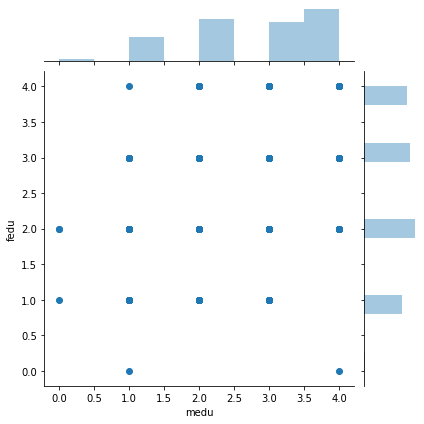

In [1052]:
# интереса ради посмотрим на совместный график этих похожих по смыслу параметров 
sns.jointplot(x='medu', y='fedu', data=stud_df, kind='scatter')

In [1053]:
# не информативно, построим по каждому значению гистограмму

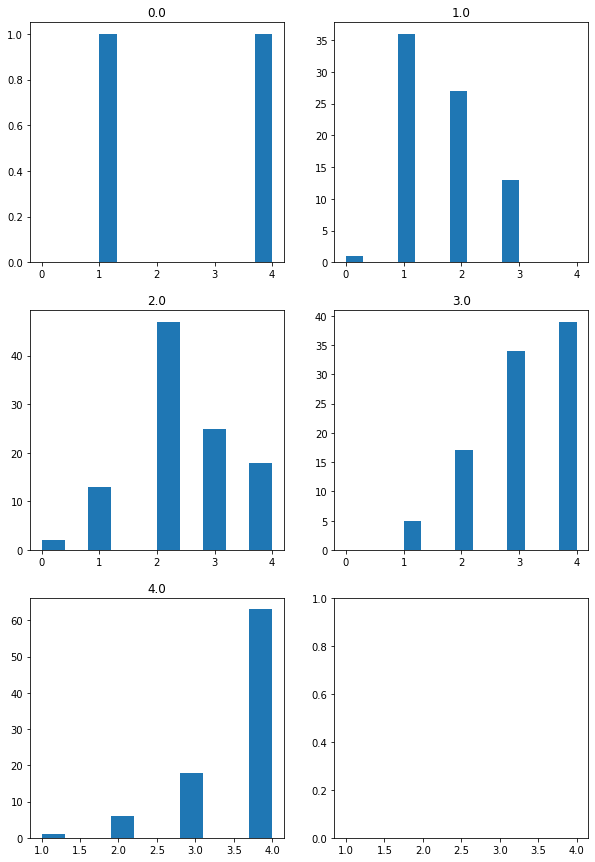

In [1054]:
by_group_hists(stud_df, 'medu', 'fedu')

In [1055]:
# не считая нуля с маленькой выборкой везде максимум где одинаковое образование!
# Более того - везде от него постепенное уменьшение, т.е. людям свойственно быть
# с людьми похожего образования.
# Таким образом, в целом подтверждается что параметры коррелируют.
# Можно заполнить NaN'ы по друг другу, например.

In [1056]:
stud_df['fedu'] = stud_df.apply(lambda row: row['fedu'] if pd.notnull(row['fedu']) else row['medu'], axis=1)
stud_df['medu'] = stud_df.apply(lambda row: row['medu'] if pd.notnull(row['medu']) else row['fedu'], axis=1)

Уникальных значений:  5
4.0    131
2.0    102
3.0     98
1.0     60
0.0      3
Name: medu, dtype: int64
Уникальных значений:  5
2.0    110
3.0    103
4.0     98
1.0     81
0.0      2
Name: fedu, dtype: int64


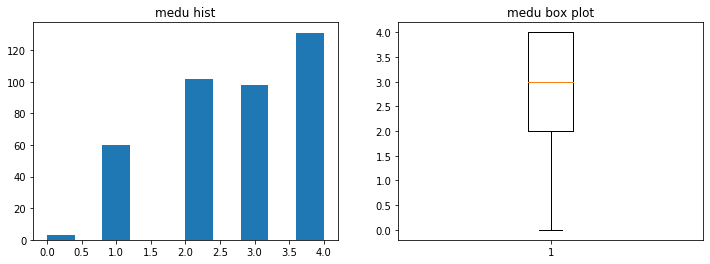

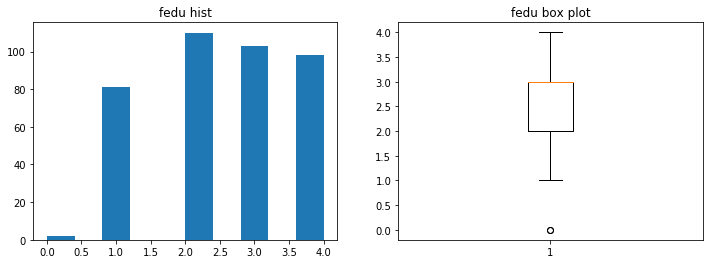

In [1057]:
# посмотрим как изменилось, у medu было всего три NaN, а вот у fedu 24.
simple_info_not_na(stud_df.medu)
simple_info_not_na(stud_df.fedu)

In [1058]:
# 9, 10. mjob, fjob

In [1059]:
# не используется
# функция перевода в числовое значение
def make_digital(edu):
    if (pd.isnull(edu)):
        return np.nan #-1
    elif (edu == 'teacher'):
        return 0
    elif (edu == 'health'):
        return 1
    elif (edu == 'services'):
        return 2
    elif (edu == 'at_home'):
        return 3
    else:
        return 4
    return 4

Уникальных значений:  5
other       133
services     97
at_home      58
teacher      55
health       32
NaN          19
Name: mjob, dtype: int64


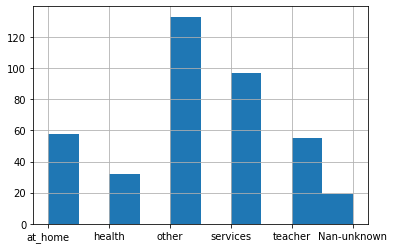

In [1060]:
simple_info_cat(stud_df.mjob)

Уникальных значений:  5
other       196
services    102
NaN          36
teacher      29
at_home      16
health       15
Name: fjob, dtype: int64


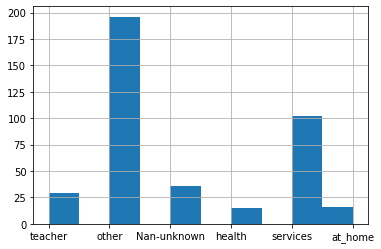

In [1061]:
simple_info_cat(stud_df.fjob)

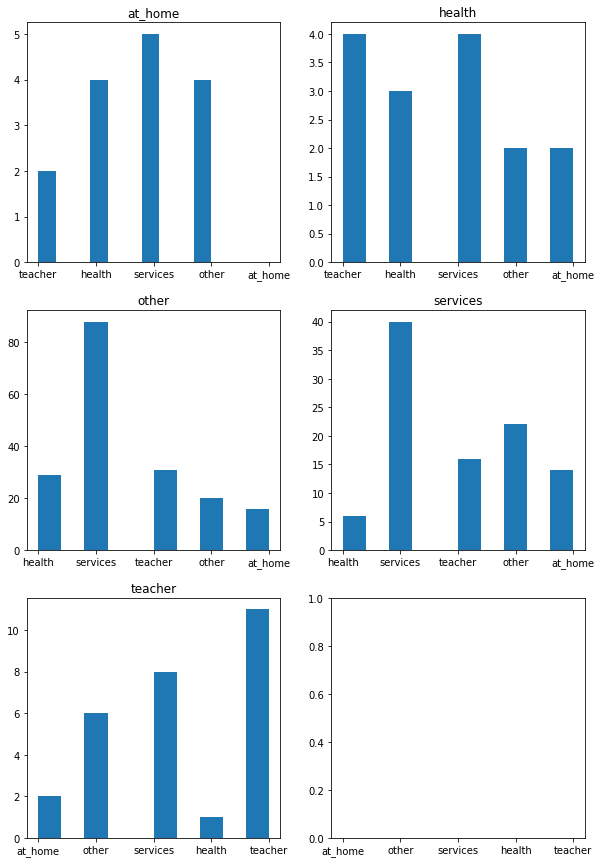

In [1062]:
by_group_hists(stud_df, 'mjob', 'fjob')

In [1063]:
# ничего не бросается в глаза, оставим

In [1064]:
# 11. reason

Уникальных значений:  4
course        137
home          104
reputation    102
other          34
NaN            17
Name: reason, dtype: int64


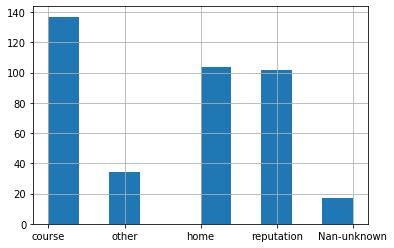

In [1065]:
simple_info_cat(stud_df.reason)

In [1066]:
# 12. guardian

Уникальных значений:  3
mother    250
father     85
NaN        31
other      28
Name: guardian, dtype: int64


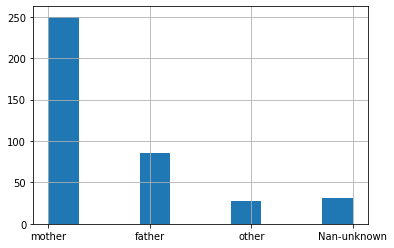

In [1067]:
simple_info_cat(stud_df.guardian)

In [1068]:
# логично предположить что если опекун не родитель то по родителям будет странная информация
# посмотрим на неё
guardian_other = stud_df.loc[stud_df.guardian == 'other']
guardian_other

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
14,GP,M,15,U,GT3,A,2.0,2.0,other,other,home,other,1.0,3.0,0.0,no,yes,no,no,yes,yes,yes,yes,4.0,5.0,2.0,3.0,0.0,80.0
127,GP,F,19,U,GT3,T,0.0,1.0,at_home,other,course,other,1.0,2.0,3.0,no,NaN,no,no,no,no,no,no,3.0,4.0,2.0,5.0,2.0,45.0
137,GP,F,16,U,GT3,A,3.0,3.0,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
152,GP,F,15,R,GT3,T,3.0,3.0,services,NaN,reputation,other,2.0,3.0,2.0,no,yes,yes,yes,NaN,yes,yes,yes,4.0,2.0,1.0,3.0,8.0,50.0
192,GP,M,17,U,GT3,T,1.0,2.0,at_home,services,other,other,2.0,2.0,0.0,no,no,NaN,yes,no,yes,yes,no,4.0,4.0,4.0,5.0,12.0,40.0
210,GP,F,19,U,GT3,NaN,3.0,3.0,other,other,reputation,other,1.0,4.0,0.0,no,yes,yes,yes,yes,yes,yes,no,4.0,3.0,3.0,3.0,10.0,40.0
244,GP,F,18,U,GT3,T,2.0,1.0,other,other,course,other,2.0,3.0,0.0,no,yes,yes,no,no,yes,yes,yes,4.0,4.0,4.0,3.0,0.0,NaN
251,GP,M,16,U,GT3,T,3.0,3.0,at_home,other,reputation,other,3.0,2.0,0.0,yes,yes,no,no,no,yes,NaN,no,5.0,3.0,3.0,2.0,6.0,50.0
270,GP,F,19,NaN,GT3,T,3.0,3.0,other,services,home,other,1.0,2.0,2.0,no,yes,yes,yes,yes,yes,yes,no,4.0,3.0,5.0,5.0,NaN,NaN
296,GP,F,19,U,GT3,T,4.0,4.0,health,other,reputation,other,2.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,2.0,3.0,4.0,2.0,0.0,0.0


In [1069]:
value_counts_short(guardian_other.medu)
value_counts_short(guardian_other.fedu)

Уникальных значений:  5
3.0    10
2.0     7
1.0     7
4.0     3
0.0     1
Name: medu, dtype: int64
Уникальных значений:  4
1.0    10
3.0     8
2.0     7
4.0     3
Name: fedu, dtype: int64


In [1070]:
value_counts_short(guardian_other.mjob)
value_counts_short(guardian_other.fjob)

Уникальных значений:  5
other       12
services     8
at_home      6
health       1
teacher      1
Name: mjob, dtype: int64
Уникальных значений:  4
other       15
services     8
NaN          3
at_home      1
health       1
Name: fjob, dtype: int64


In [1071]:
# сказать про связь guardian c ними по-прежнему нечего

In [1072]:
# 13. traveltime

Уникальных значений:  4
1.0    242
2.0     96
NaN     28
3.0     21
4.0      7
Name: traveltime, dtype: int64


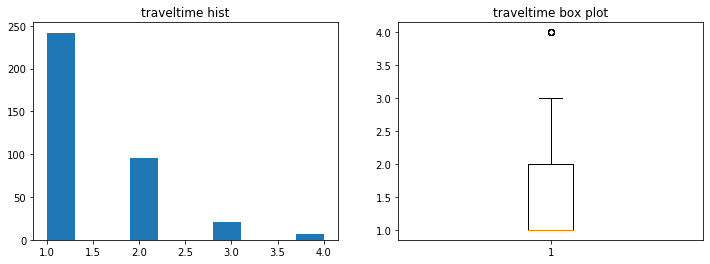

In [1073]:
simple_info_not_na(stud_df.traveltime)

In [1074]:
# 4 как будто бы выброс, но учитывая специфику смысла значения - просто редкое значение

In [1075]:
# 14. studytime

Уникальных значений:  4
2.0    194
1.0    103
3.0     63
4.0     27
NaN      7
Name: studytime, dtype: int64


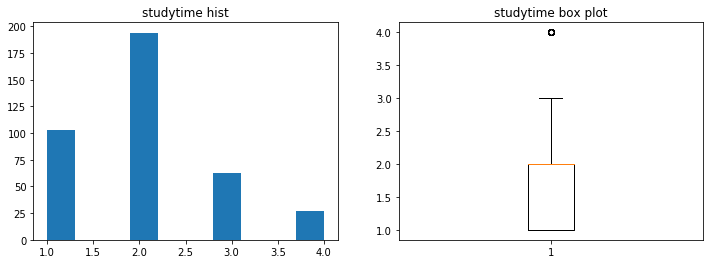

In [1076]:
simple_info_not_na(stud_df.studytime)

In [1077]:
# 4 как будто бы выброс, но учитывая специфику смысла значения - просто редкое значение

In [1078]:
# 15. failures 

Уникальных значений:  4
0.0    292
1.0     49
NaN     22
2.0     16
3.0     15
Name: failures, dtype: int64


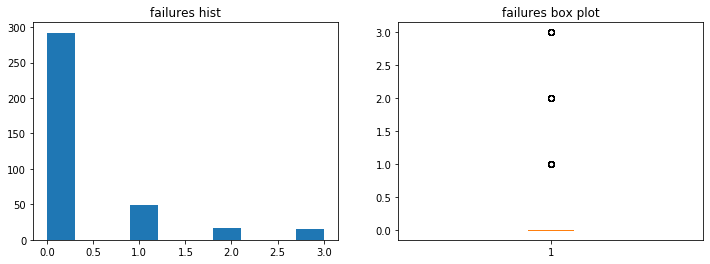

In [1079]:
simple_info_not_na(stud_df.failures)

In [1081]:
# кажется что смысл значения 0 малоинформативен,
# так как может содержать в себе противоположные по значению смыслы.
# Из-за этого же и кажущиеся как выбросы нормальные значения 

In [1082]:
# 16-17. schoolsup, famsup  

Уникальных значений:  2
no     334
yes     51
NaN      9
Name: schoolsup, dtype: int64


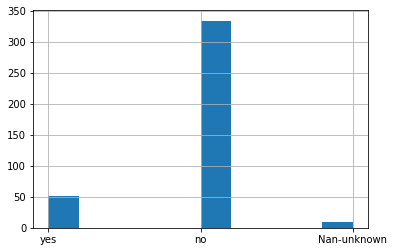

In [1083]:
simple_info_cat(stud_df.schoolsup)

Уникальных значений:  2
yes    218
no     137
NaN     39
Name: famsup, dtype: int64


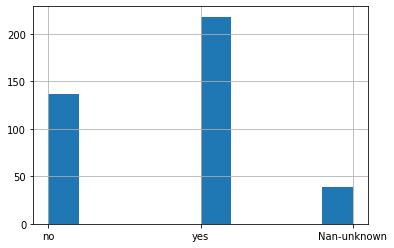

In [1084]:
simple_info_cat(stud_df.famsup)

In [1085]:
# 18-19. paid, activities  

Уникальных значений:  2
no     199
yes    155
NaN     40
Name: paid, dtype: int64


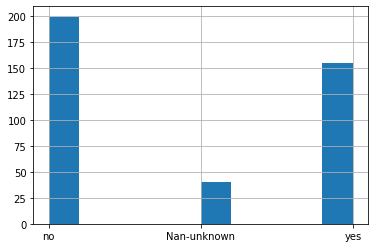

In [1086]:
simple_info_cat(stud_df.paid)

Уникальных значений:  2
yes    194
no     186
NaN     14
Name: activities, dtype: int64


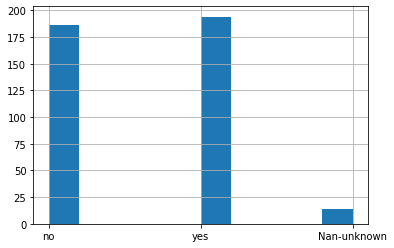

In [1087]:
simple_info_cat(stud_df.activities)

In [1088]:
# 20 nursery

Уникальных значений:  2
yes    299
no      79
NaN     16
Name: nursery, dtype: int64


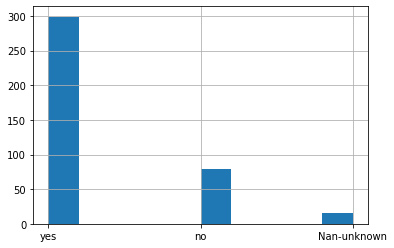

In [1089]:
simple_info_cat(stud_df.nursery)

In [1090]:
#21 higher

Уникальных значений:  2
yes    355
NaN     20
no      19
Name: higher, dtype: int64


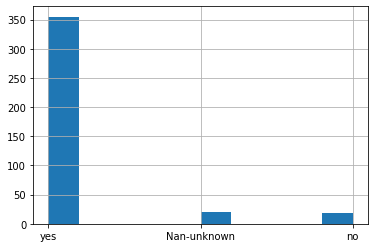

In [1091]:
simple_info_cat(stud_df.higher)

In [1092]:
#22 internet 

Уникальных значений:  2
yes    304
no      56
NaN     34
Name: internet, dtype: int64


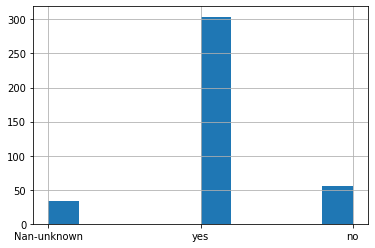

In [1093]:
simple_info_cat(stud_df.internet )

In [1094]:
#23 romantic 

Уникальных значений:  2
no     239
yes    124
NaN     31
Name: romantic, dtype: int64


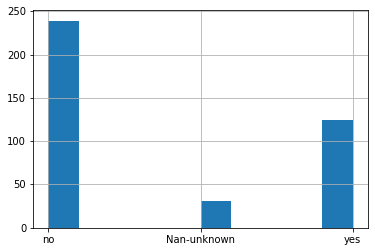

In [1095]:
simple_info_cat(stud_df.romantic )

In [1096]:
#24 famrel 

Уникальных значений:  6
 4.0    182
 5.0     98
 3.0     62
 NaN     27
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64


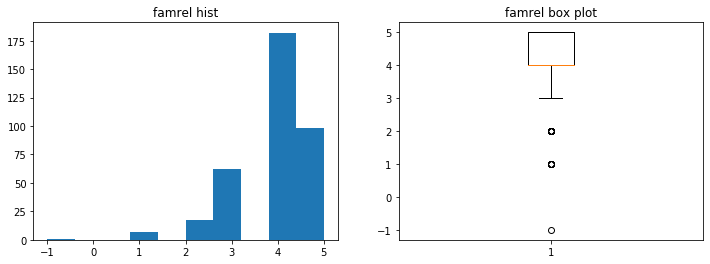

In [1097]:
simple_info_not_na(stud_df.famrel)

Уникальных значений:  5
4.0    182
5.0     98
3.0     62
NaN     27
2.0     17
1.0      7
Name: famrel, dtype: int64


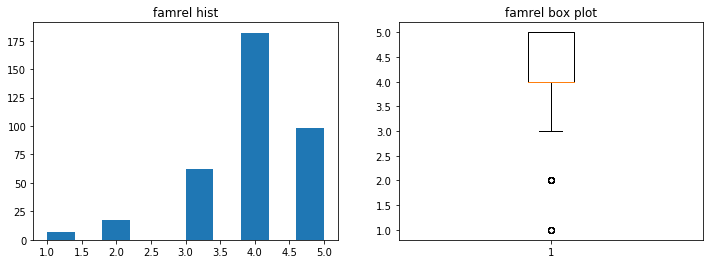

In [1098]:
# удалим явно неверные значения и перепостроим
stud_df = stud_df.loc[(stud_df.famrel >= 0.0) | (pd.isnull(stud_df.famrel))]
simple_info_not_na(stud_df.famrel)

In [1099]:
# выбросы как было ранее - специфика смысла

In [1100]:
#25 freetime 

Уникальных значений:  5
3.0    153
4.0    112
2.0     61
5.0     38
1.0     18
NaN     11
Name: freetime, dtype: int64


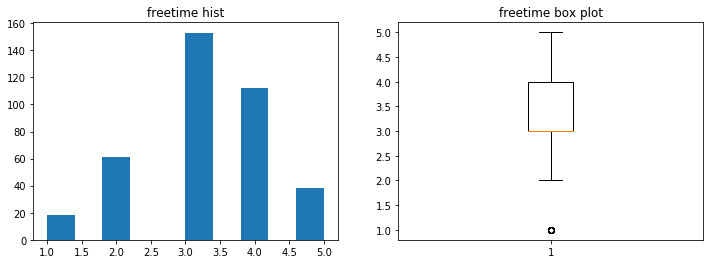

In [1101]:
simple_info_not_na(stud_df.freetime )

In [1102]:
# выбросы как было ранее - специфика смысла

In [1103]:
#26 goout 

Уникальных значений:  5
3.0    127
2.0     99
4.0     84
5.0     52
1.0     23
NaN      8
Name: goout, dtype: int64


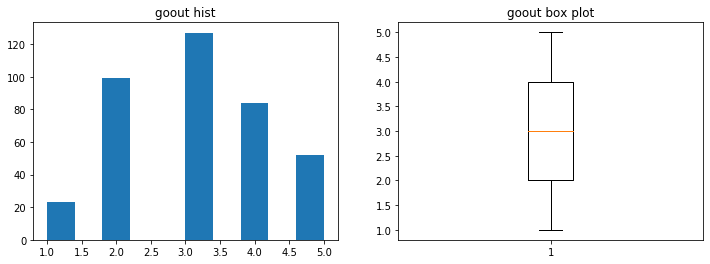

In [1104]:
simple_info_not_na(stud_df.goout )

In [1105]:
#27 health 

Уникальных значений:  5
5.0    137
3.0     89
4.0     62
1.0     47
2.0     43
NaN     15
Name: health, dtype: int64


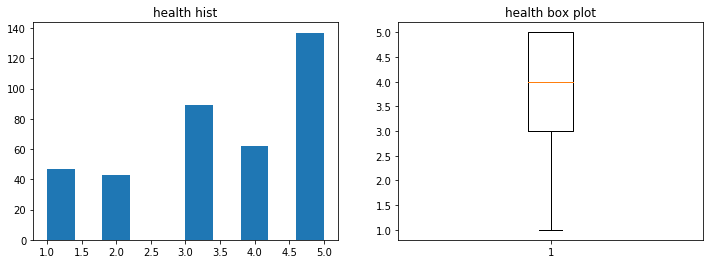

In [1106]:
simple_info_not_na(stud_df.health )

In [1107]:
#28 absences 

In [1108]:
# получим частоту и посмотрем на значения
stud_df.absences.value_counts().sort_index()

0.0      111
1.0        3
2.0       60
3.0        8
4.0       52
5.0        5
6.0       31
7.0        6
8.0       21
9.0        3
10.0      17
11.0       2
12.0      12
13.0       2
14.0      11
15.0       2
16.0       7
17.0       1
18.0       5
19.0       1
20.0       4
21.0       1
22.0       3
23.0       1
24.0       1
25.0       1
26.0       1
28.0       1
30.0       1
38.0       1
40.0       1
54.0       1
56.0       1
75.0       1
212.0      1
385.0      1
Name: absences, dtype: int64

Уникальных значений:  36
0.0      111
2.0       60
4.0       52
6.0       31
8.0       21
10.0      17
NaN       12
12.0      12
14.0      11
3.0        8
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
9.0        3
1.0        3
22.0       3
13.0       2
11.0       2
15.0       2
17.0       1
21.0       1
23.0       1
40.0       1
38.0       1
19.0       1
30.0       1
75.0       1
212.0      1
24.0       1
56.0       1
26.0       1
385.0      1
54.0       1
25.0       1
28.0       1
Name: absences, dtype: int64


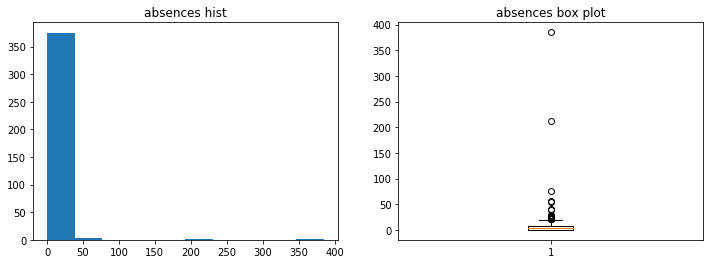

In [1109]:
simple_info_not_na(stud_df.absences)

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


(8.0, 0.0, 8.0)

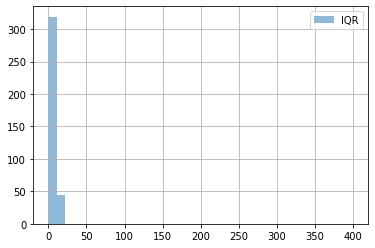

In [1110]:
# посмотрим на квантили и IQR
pic_iqr_global(stud_df.absences, 36, 0, 400)

In [1111]:
# по смыслу кажется что 212 и 385 выбросы, либо кто-то не ходил или был экстерном, посмотрим на них

In [1112]:
stud_df[stud_df.absences > 200.0]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0


In [1113]:
# как мусор не выглядит - оставим

In [1114]:
#29 score

Уникальных значений:  18
50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
60.0     30
40.0     30
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
NaN       6
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64


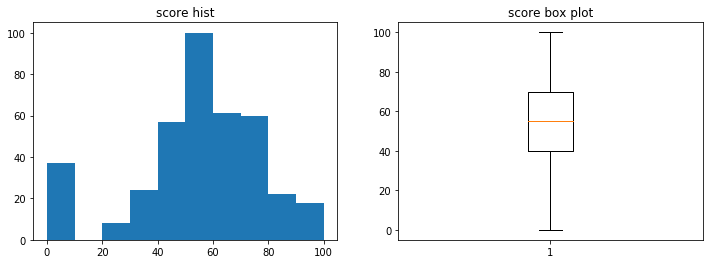

In [1115]:
simple_info_not_na(stud_df.score)

In [1116]:
# значение 0 выглядит немного странно - и как не пришли и как полный провал,
# но понимания что надо удалить - нету

In [1117]:
# удалим NaN для score - цель понять что влияет на него, по NaN не понять
stud_df = stud_df.loc[pd.notnull(stud_df.score)]

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


(30.0, 40.0, 70.0)

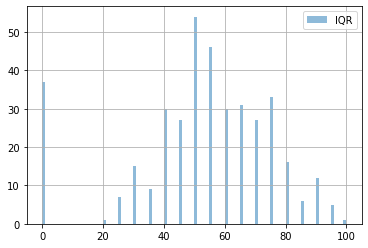

In [1118]:
pic_iqr_global(stud_df.score, 100, 0, 100)

In [1120]:
# Всё-таки разрыв перед 0 очень подозрителен
# сделаем отдельную выборку без него
stud_df_not0 = stud_df.loc[stud_df.score > 0]

# 3. Анализ количественных переменных с помощью корреляционного анализа (анализ подробней)

### Отметим, что 
1) 'medu', 'fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health' по сути номинативные. Позже мы проанализируем их как номинативные тоже.

2) там где анализируем ниже нижнего порога (так сказать "хоть что-то", мы не говорим о корреляции в явном виде, просто хочется понять

In [1121]:
# повторим корреляционный анализ

---------Correlated---------
---------end--------
---------Just something correlated---------
medu 	 age 	 -0.14972127075331937
fedu 	 age 	 -0.15779590097204818
fedu 	 medu 	 0.6511530329781865
traveltime 	 medu 	 -0.15934433147032417
failures 	 age 	 0.20994579127882407
failures 	 medu 	 -0.23761541838360523
failures 	 fedu 	 -0.2603768435994711
failures 	 studytime 	 -0.17463930526557128
freetime 	 famrel 	 0.1675137001098581
goout 	 freetime 	 0.291681172077313
score 	 age 	 -0.15580234477987379
score 	 medu 	 0.2189231673520955
score 	 failures 	 -0.34338502071056315
---------end--------


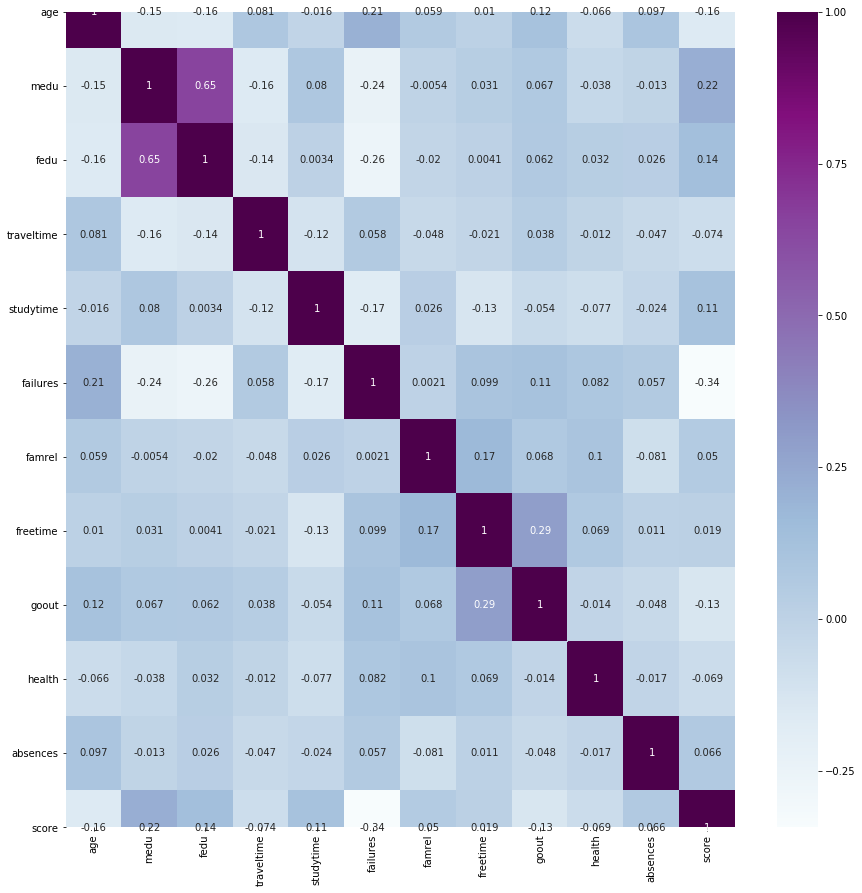

In [1122]:
correlation_workflow(stud_df, threshold_corr, threshold_corr_at_least)

In [1124]:
# как видим из числовых кажется ничто особо не коррелирует, даже fedu/medu
# в хоть что-то можно при желании и додумывании увидеть смысловую связь некоторого количества признаков,
# но явно не прямую, а только частичную

---------Correlated---------
---------end--------
---------Just something correlated---------
fedu 	 medu 	 0.6359165306691197
traveltime 	 medu 	 -0.15954621198991695
traveltime 	 fedu 	 -0.15406821613151053
failures 	 age 	 0.24168761009561257
failures 	 medu 	 -0.20083974141753028
failures 	 fedu 	 -0.2554672399440095
freetime 	 famrel 	 0.15411856423069156
goout 	 freetime 	 0.291143422102336
score 	 medu 	 0.1913608273367783
score 	 failures 	 -0.28421213773312604
score 	 goout 	 -0.18597745997319917
---------end--------


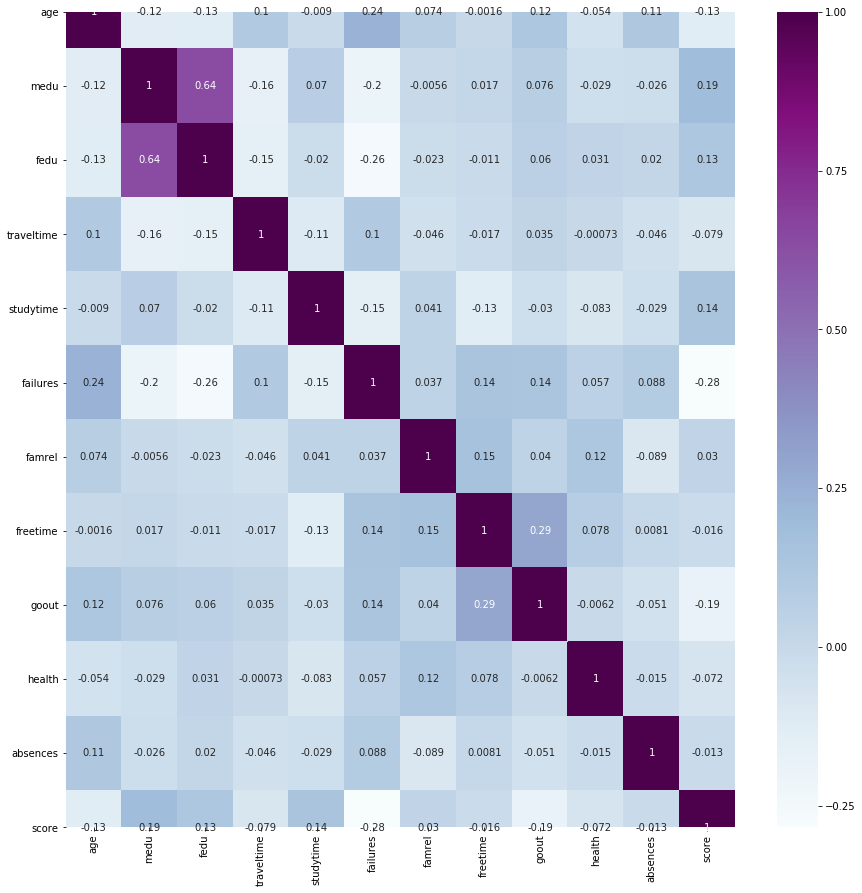

In [1125]:
# теперь посмотрим без нулевого score
correlation_workflow(stud_df_not0, threshold_corr, threshold_corr_at_least)

In [906]:
# Видим, что корреляция score с age, medu и failures стала ещё меньше, зато стала чуть больше goout 
# (но конечно тут на видимые изменения ещё влияет выбранный мной порог)

---------Correlated---------
fedu 	 medu 	 0.7039991072429403
---------end--------
---------Just something correlated---------
fedu 	 medu 	 0.7039991072429403
traveltime 	 age 	 0.15401269325980582
traveltime 	 medu 	 -0.2142623923767937
studytime 	 age 	 -0.19805742818604777
failures 	 age 	 0.32154575216842207
failures 	 fedu 	 -0.17648478370178594
freetime 	 studytime 	 -0.22722901196557957
goout 	 freetime 	 0.3709015393428416
health 	 famrel 	 0.1774919867187472
absences 	 failures 	 0.23776649001416458
score 	 age 	 -0.1770114330360132
score 	 failures 	 -0.3180822708692036
---------end--------


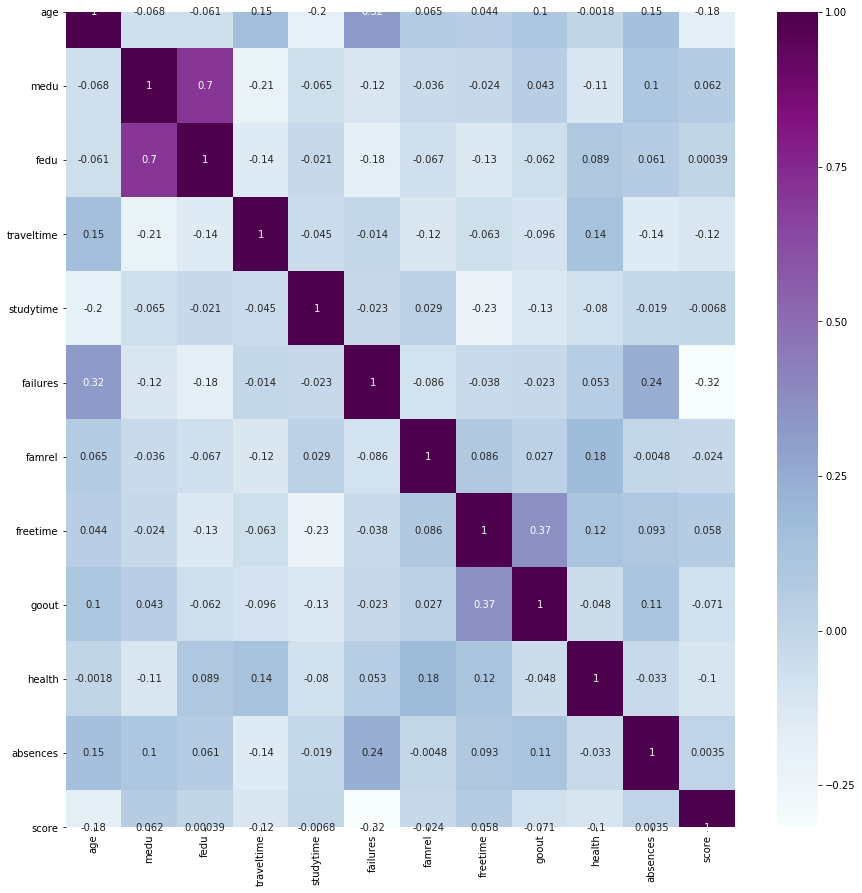

In [1126]:
# попробуем ещё раз без NaN
correlation_workflow(clean_df(stud_df), threshold_corr, threshold_corr_at_least)

In [822]:
# как видим - ситуация та же, за исключением fedu/medu, который стал чуть явнее

---------Correlated---------
fedu 	 medu 	 0.7089535106719084
---------end--------
---------Just something correlated---------
fedu 	 medu 	 0.7089535106719084
traveltime 	 age 	 0.16800139994062271
traveltime 	 medu 	 -0.23741358654120226
traveltime 	 fedu 	 -0.17278774696528382
studytime 	 age 	 -0.25891179397556285
failures 	 age 	 0.39158785655838696
failures 	 fedu 	 -0.23335648307066045
freetime 	 studytime 	 -0.24379465803882633
goout 	 freetime 	 0.3701213973378875
health 	 famrel 	 0.1595100070140778
absences 	 age 	 0.18845604589731801
absences 	 traveltime 	 -0.15080227874765886
absences 	 failures 	 0.2997371057472636
score 	 traveltime 	 -0.1587439934016799
score 	 failures 	 -0.31385574612164313
score 	 absences 	 -0.21045077683941182
---------end--------


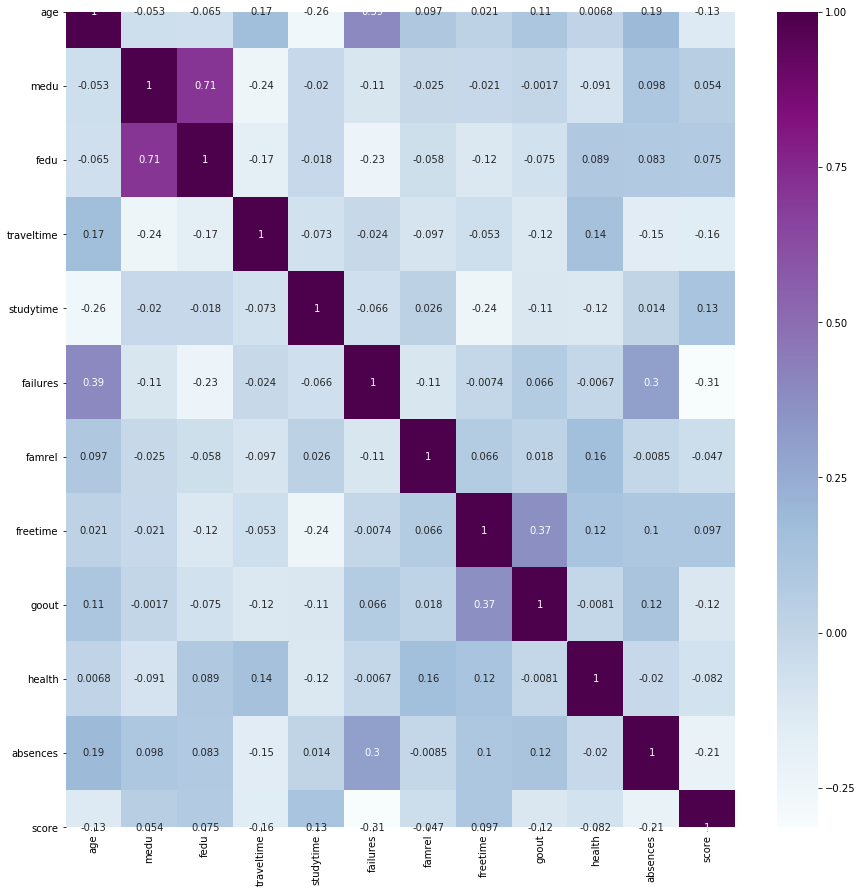

In [1127]:
# теперь попробуем без нулевого score и ещё и без NaN
correlation_workflow(clean_df(stud_df_not0), threshold_corr, threshold_corr_at_least)

In [908]:
# Видим, что корреляция score с age стала ещё меньше, failures осталась, зато стала чуть больше traveltime и absences 
# (но конечно тут на видимые изменения ещё влияет выбранный мной порог)

### Везде в целом видим отсутствие корреляции со score

In [1128]:
# получим список номинативных и количественных переменных (score сразу из изучаемого списка исключаем)
obj_col_list = []
num_col_list1 = []
for tt in range(len(stud_df.dtypes)-1):
    if (stud_df.dtypes.iloc[tt] == 'object'):
        obj_col_list.append(stud_df.dtypes.index[tt])
    else:
        num_col_list1.append(stud_df.dtypes.index[tt])
    #print(stud_df.dtypes.iloc[tt], stud_df.dtypes.index[tt])
obj_col_list, num_col_list1

(['school',
  'sex',
  'address',
  'famsize',
  'pstatus',
  'mjob',
  'fjob',
  'reason',
  'guardian',
  'schoolsup',
  'famsup',
  'paid',
  'activities',
  'nursery',
  'higher',
  'internet',
  'romantic'],
 ['age',
  'medu',
  'fedu',
  'traveltime',
  'studytime',
  'failures',
  'famrel',
  'freetime',
  'goout',
  'health',
  'absences'])

In [914]:
# список колонок с циферными значениями, которые по сути номинативные
like_an_obj = ['medu', 'fedu', 'traveltime', 'studytime', 'failures', 
               'famrel', 'freetime', 'goout', 'health']

In [969]:
# финальный список для номинативного анализа
final_obj_list = obj_col_list + like_an_obj

In [970]:
# финальный список для номинативного анализа
num_col_list = []
for t in num_col_list1:
    if t not in final_obj_list: 
        num_col_list.append(t)
num_col_list

['age', 'absences']

In [886]:
final_obj_list

['school',
 'sex',
 'address',
 'famsize',
 'pstatus',
 'mjob',
 'fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'medu',
 'fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'health']

In [953]:
# найти статистически значимые различия без учета NaN
def get_stat_dif_no_na(input_df, column):
    cols = input_df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(input_df.loc[input_df.loc[:, column] == comb[0], 'score'].dropna(), 
                        input_df.loc[input_df.loc[:, column] == comb[1], 'score'].dropna()).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
    #else:
    #    print("no", column)

In [954]:
for col in final_obj_list:
    get_stat_dif_no_na(stud_df, col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки fedu
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки goout


In [955]:
for col in final_obj_list:
    get_stat_dif(stud_df, col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки fedu
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки goout


In [956]:
cleaned_df2 = clean_df(stud_df)
for col in final_obj_list:
    get_stat_dif222(cleaned_df2, col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Найдены статистически значимые различия для колонки failures


In [957]:
for col in final_obj_list:
    get_stat_dif(cleaned_df2, col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки failures


In [895]:
# боксплоты для каждого столбца
def boxplots_by_column(inpit_df, final_obj_list):
    rowc = int(len(final_obj_list)/3)+1
    f, axes = plt.subplots(rowc, 3, figsize=(15, 5*rowc))

    a = axes.ravel()
    cnt_id = 0
    for idx,ax in enumerate(a):
        if (cnt_id >= len(final_obj_list)):
            break
        sns.boxplot(x=final_obj_list[idx], y='score', 
                data=inpit_df.loc[inpit_df.loc[:, final_obj_list[idx]].isin(inpit_df.loc[:, final_obj_list[idx]].value_counts().index[:10])],
               ax=ax)
        ax.set_title(final_obj_list[cnt_id])
        cnt_id = cnt_id + 1

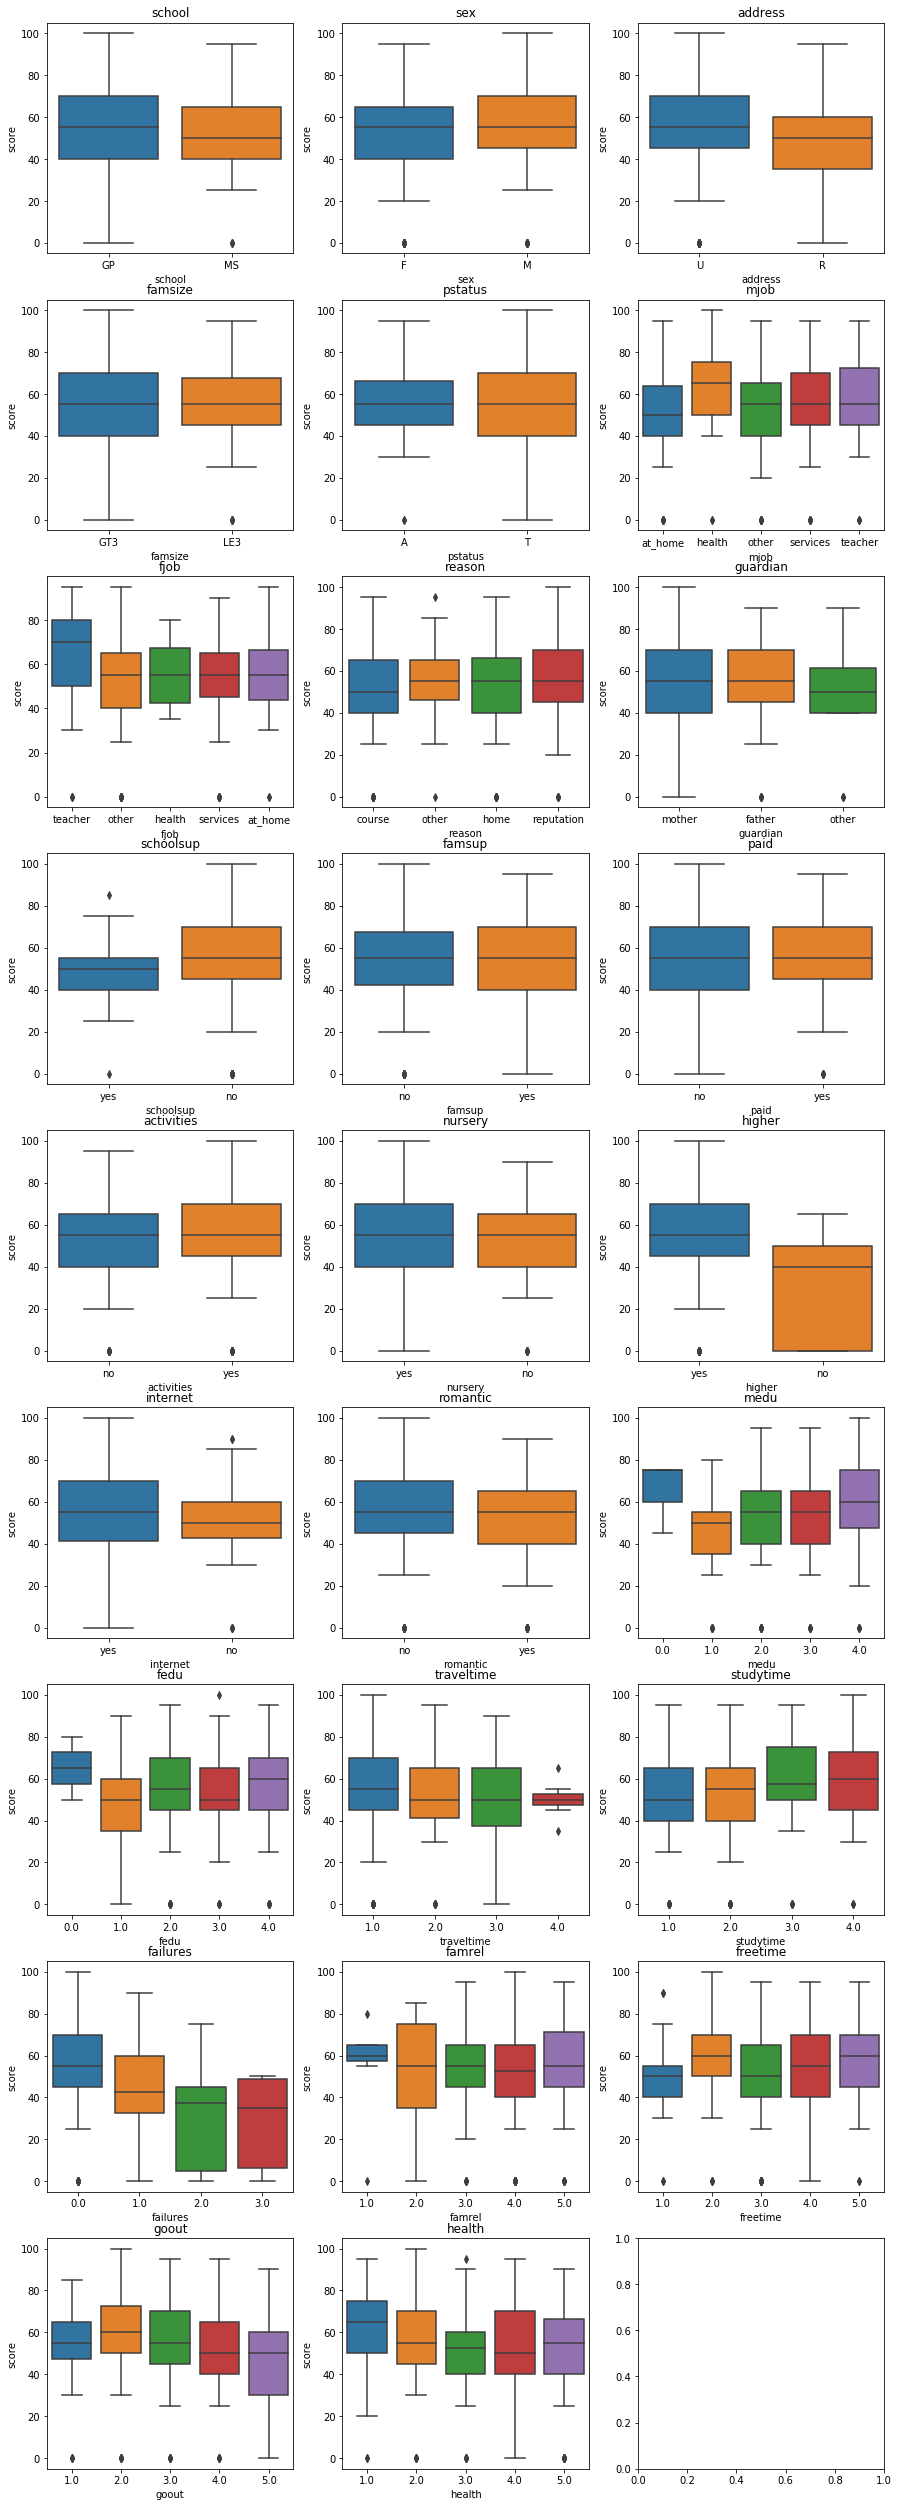

In [896]:
boxplots_by_column(stud_df, final_obj_list)

In [901]:
# боксплоты для каждого столбца
def boxplots_by_column222(inpit_df, final_obj_list):
    rowc = int(len(final_obj_list)/3)+1
    f, axes = plt.subplots(rowc, 3, figsize=(15, 5*rowc))

    a = axes.ravel()
    cnt_id = 0
    for idx,ax in enumerate(a):
        if (cnt_id >= len(final_obj_list)):
            break
        sns.boxplot(x=final_obj_list[idx], y='score', 
                data=inpit_df,
               ax=ax)
        ax.set_title(final_obj_list[cnt_id])
        cnt_id = cnt_id + 1

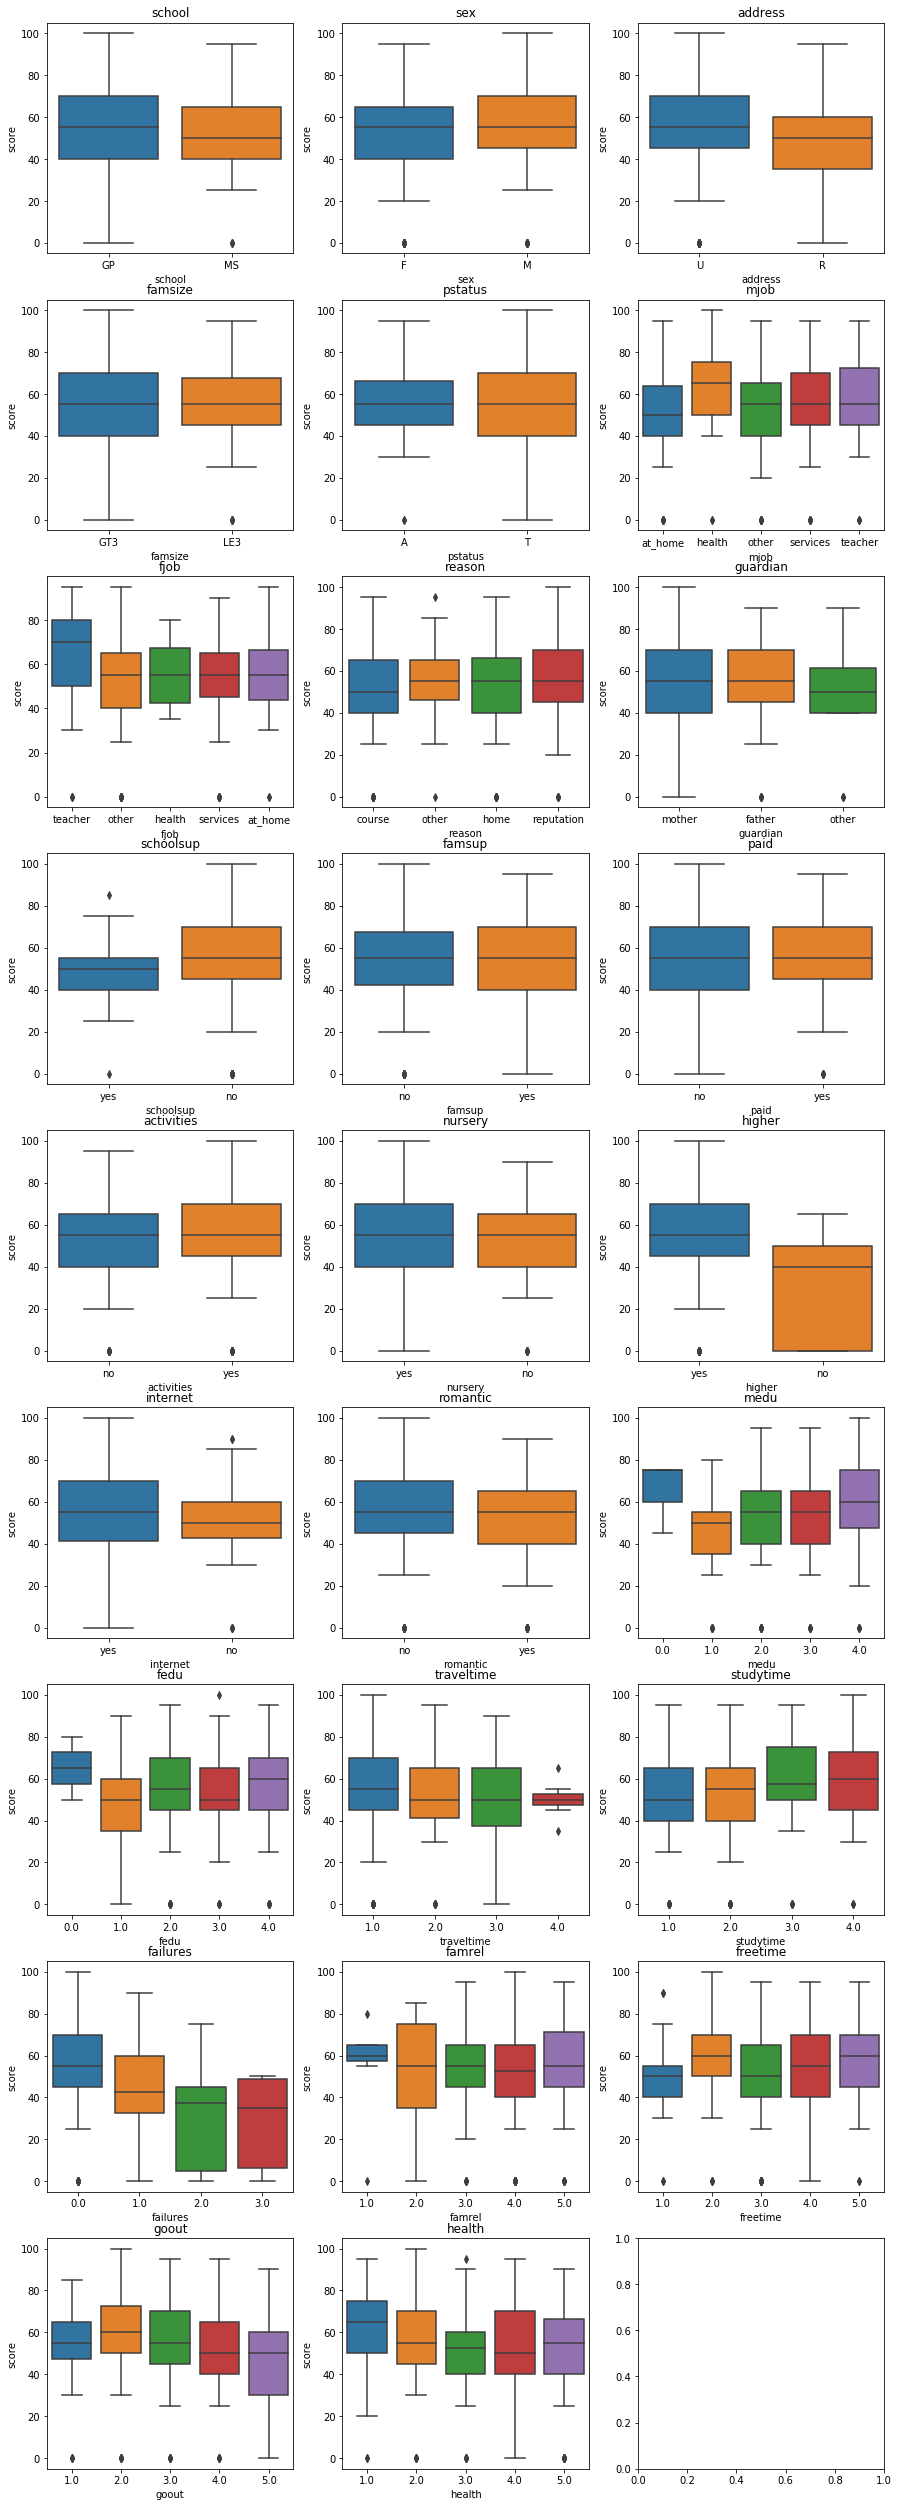

In [902]:
boxplots_by_column222(stud_df, final_obj_list)

In [959]:
# создадим копию для заполнения NaN
stud_df_replace_nan = stud_df.copy()

In [960]:
for col in final_obj_list:
    vc = stud_df[col].value_counts()
    stud_df_replace_nan[col] = stud_df.apply(lambda row: row[col] if pd.notnull(row[col]) else vc.index[0], axis=1)

In [971]:
for col in num_col_list:
    median_col_value = stud_df[col].median()
    stud_df_replace_nan[col] = stud_df.apply(lambda row: row[col] if pd.notnull(row[col]) else median_col_value, axis=1)

In [972]:
for col in final_obj_list:
    get_stat_dif(stud_df_replace_nan, col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки fedu
Найдены статистически значимые различия для колонки failures


In [973]:
stud_df_replace_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 0 to 394
Data columns (total 29 columns):
school        387 non-null object
sex           387 non-null object
age           387 non-null int64
address       387 non-null object
famsize       387 non-null object
pstatus       387 non-null object
medu          387 non-null float64
fedu          387 non-null float64
mjob          387 non-null object
fjob          387 non-null object
reason        387 non-null object
guardian      387 non-null object
traveltime    387 non-null float64
studytime     387 non-null float64
failures      387 non-null float64
schoolsup     387 non-null object
famsup        387 non-null object
paid          387 non-null object
activities    387 non-null object
nursery       387 non-null object
higher        387 non-null object
internet      387 non-null object
romantic      387 non-null object
famrel        387 non-null float64
freetime      387 non-null float64
goout         387 non-null float64
heal

## 5. Выводы 

#### 1. Достаточно немало NaN, но при этом в каждой колонке относительно немного